# ECON 220 Lab - Week 11

Justin S. Eloriaga

Today, the focus is to understand one of the more useful statistical methods which you may likely use for research. This is known as the ANOVA, or the Analysis of Variance Framework

Let us first load up the dataset we used last week. We will use the same one for continuity purposes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
path = "/Users/justineloriaga/Documents/GitHub/ECON-220-Lab/Week 10/cps09mar.xlsx"

data = pd.read_excel(path)
data

,age,female,hisp,education,earnings,hours,week,union,uncov,region,race,marital
0,52,0,0,12,146000,45,52,0,0,1,1,1
1,38,0,0,18,50000,45,52,0,0,1,1,1
2,38,0,0,14,32000,40,51,0,0,1,1,1
3,41,1,0,13,47000,40,52,0,0,1,1,1
4,42,0,0,13,161525,50,52,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
50737,58,1,0,11,30000,40,52,0,0,4,4,6
50738,62,1,0,16,35000,40,52,0,0,4,4,6
50739,58,0,0,12,75000,50,52,0,0,4,1,1
50740,45,1,0,12,40000,60,52,0,0,4,1,1


One variable I would like to look at is Education. However, it has so many categories. I need to try and reduce those to a few. Let me define a function that can do that

In [6]:
def map_education(code):
    if code in [0, 4, 6, 8, 9, 10, 11]:
        return "No HS Diploma"
    elif code in [12, 13]:
        return "HS Diploma"
    elif code == 14:
        return "Associate Degree"
    elif code == 16:
        return "Bachelor Degree"
    elif code in [18, 20]:
        return "Graduate Degree"
    else:
        return "Other"

# Apply the mapping function to create the new column
data['educ_new'] = data['education'].apply(map_education)
data.head()

,age,female,hisp,education,earnings,hours,week,union,uncov,region,race,marital,educ_new
0,52,0,0,12,146000,45,52,0,0,1,1,1,HS Diploma
1,38,0,0,18,50000,45,52,0,0,1,1,1,Graduate Degree
2,38,0,0,14,32000,40,51,0,0,1,1,1,Associate Degree
3,41,1,0,13,47000,40,52,0,0,1,1,1,HS Diploma
4,42,0,0,13,161525,50,52,1,0,1,1,1,HS Diploma


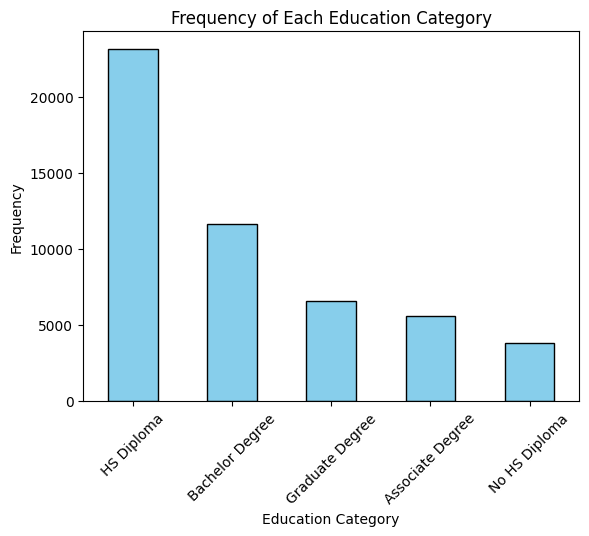

In [7]:
# Calculate frequency of each educ_new category
educ_counts = data['educ_new'].value_counts()

# Plot the bar chart
educ_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency of Each Education Category')
plt.xlabel('Education Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Suppose I posed the following research question: “Is there a significant difference in average earnings across different levels of education among U.S. workers?”

<Figure size 1000x600 with 0 Axes>

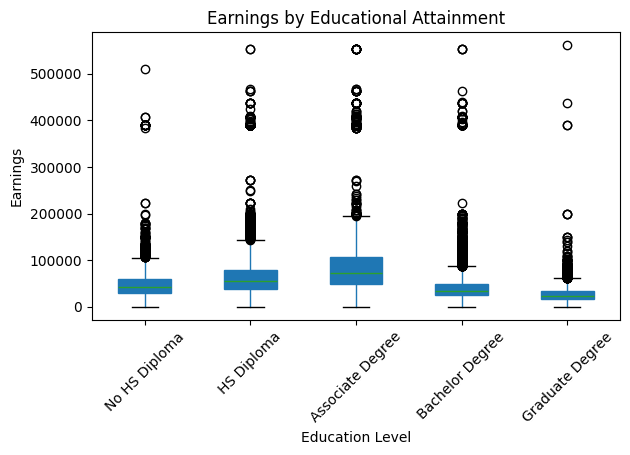

In [9]:
# Make sure 'educ_new' is treated as a categorical variable with ordered categories
category_order = [
    "No HS Diploma", 
    "HS Diploma", 
    "Associate Degree", 
    "Bachelor Degree", 
    "Graduate Degree"
]

# Filter out any rows with missing or "Other" education categories if they exist
filtered_data = data[data['educ_new'].isin(category_order)]

# Create the boxplot
plt.figure(figsize=(10, 6))
filtered_data.boxplot(column='earnings', by='educ_new', grid=False, patch_artist=True)

# Enhance plot aesthetics
plt.title("Earnings by Educational Attainment")
plt.suptitle("")  # Remove the automatic title that pandas adds
plt.xlabel("Education Level")
plt.ylabel("Earnings")
plt.xticks(ticks=range(1, len(category_order) + 1), labels=category_order, rotation=45)
plt.tight_layout()

plt.show()

Note that if the boxes (i.e., medians, spreads) look visibly different across groups, that’s a good visual clue that the means might be significantly different, which is exactly what ANOVA tests for.

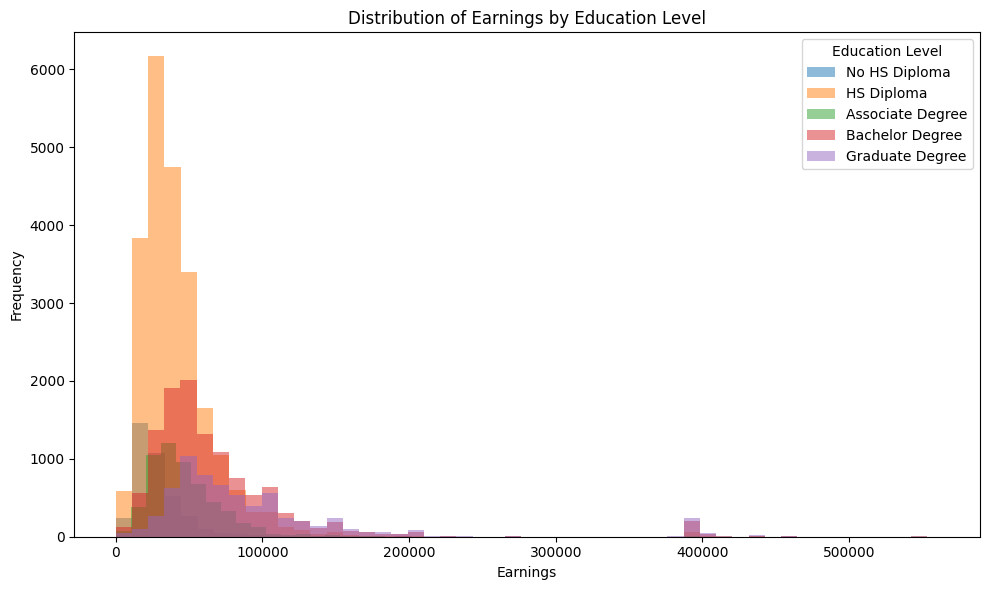

In [10]:
# Set up figure
plt.figure(figsize=(10, 6))

# Define education categories in desired order
category_order = [
    "No HS Diploma", 
    "HS Diploma", 
    "Associate Degree", 
    "Bachelor Degree", 
    "Graduate Degree"
]

# Loop over each category and plot a histogram of earnings
for educ in category_order:
    subset = data[data['educ_new'] == educ]
    plt.hist(subset['earnings'], bins=50, alpha=0.5, label=educ)

# Add labels and legend
plt.title("Distribution of Earnings by Education Level")
plt.xlabel("Earnings")
plt.ylabel("Frequency")
plt.legend(title="Education Level")
plt.tight_layout()
plt.show()

Nice graph, but clearly, there are outlying observations. There are many ways to deal with this, but one way is to just cut the 99th percentile.

In [11]:
# Calculate the 99th percentile of earnings
earnings_99 = data['earnings'].quantile(0.99)

# Filter the data to exclude the top 1% of earners
trimmed_data = data[data['earnings'] <= earnings_99]

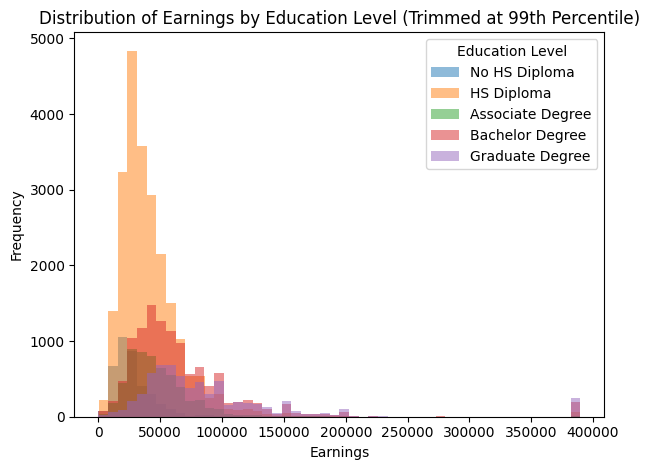

In [12]:
for educ in category_order:
    subset = trimmed_data[trimmed_data['educ_new'] == educ]
    plt.hist(subset['earnings'], bins=50, alpha=0.5, label=educ)

plt.title("Distribution of Earnings by Education Level (Trimmed at 99th Percentile)")
plt.xlabel("Earnings")
plt.ylabel("Frequency")
plt.legend(title="Education Level")
plt.tight_layout()
plt.show()

Now that we have motivated it greatly, let us run a One-Way ANOVA

In [13]:
from scipy.stats import f_oneway

# Prepare the earnings data grouped by education level
groups = []
for educ in category_order:
    group_earnings = trimmed_data[trimmed_data['educ_new'] == educ]['earnings']
    groups.append(group_earnings)

# Run one-way ANOVA
f_stat, p_value = f_oneway(*groups)

# Print results
print(f"F-statistic: {f_stat:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Result: Significant differences in mean earnings across education levels (reject H0)")
else:
    print("Result: No significant difference in mean earnings across education levels (fail to reject H0)")

F-statistic: 2399.81
P-value: 0.0000
Result: Significant differences in mean earnings across education levels (reject H0)


Clearly, since we have a very high F stat and a very low P-value, we reject the claim that there is no significant difference in mean earnings. As such, we conclude that there is a significant difference in mean earnings across education levels

We now know a good result, but is always good to know the granularity of such. One important extension is called the Tukey HSD (Honestly Significant Difference) test. This will allow us to specifically pinpoint which education groups differ in terms of mean earnings

In [14]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Run Tukey HSD
tukey = pairwise_tukeyhsd(
    endog=trimmed_data['earnings'],       # the data
    groups=trimmed_data['educ_new'],      # group labels
    alpha=0.05                            # significance level
)

# Print the summary
print(tukey.summary())

               Multiple Comparison of Means - Tukey HSD, FWER=0.05               
     group1           group2       meandiff  p-adj    lower       upper    reject
---------------------------------------------------------------------------------
Associate Degree Bachelor Degree  20241.3764   0.0  18327.9867  22154.7661   True
Associate Degree Graduate Degree  43718.5809   0.0   41571.035  45866.1269   True
Associate Degree      HS Diploma  -6551.1191   0.0  -8301.9399  -4800.2984   True
Associate Degree   No HS Diploma -19533.3982   0.0 -22005.1065 -17061.6898   True
 Bachelor Degree Graduate Degree  23477.2045   0.0  21650.0496  25304.3595   True
 Bachelor Degree      HS Diploma -26792.4956   0.0 -28131.1197 -25453.8714   True
 Bachelor Degree   No HS Diploma -39774.7746   0.0 -41973.8389 -37575.7103   True
 Graduate Degree      HS Diploma -50269.7001   0.0 -51925.8426 -48613.5576   True
 Graduate Degree   No HS Diploma -63251.9791   0.0 -65657.5512  -60846.407   True
      HS Diploma

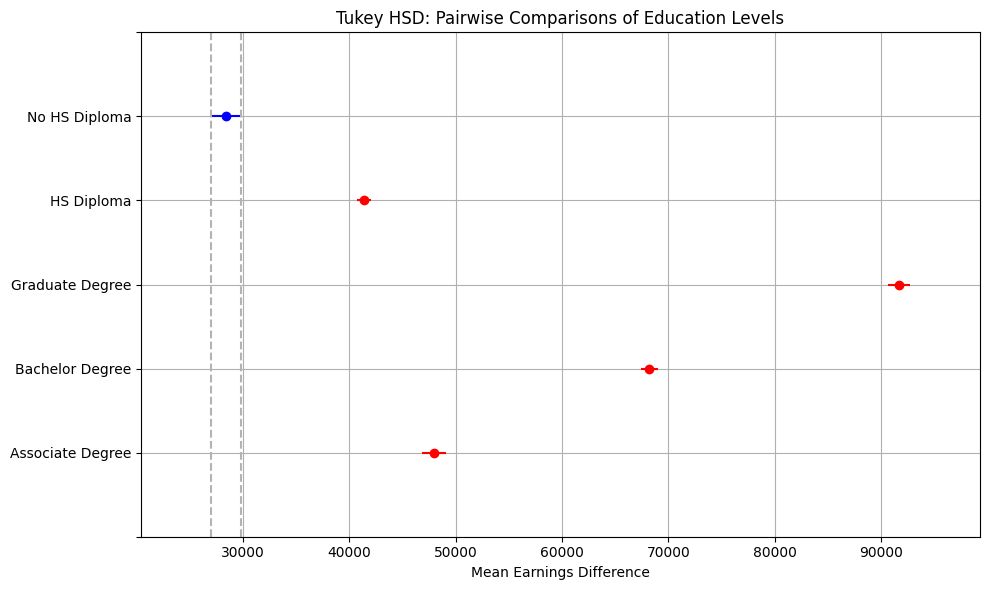

In [15]:
# Plot the results
tukey.plot_simultaneous(comparison_name='No HS Diploma', figsize=(10, 6))
plt.title("Tukey HSD: Pairwise Comparisons of Education Levels")
plt.xlabel("Mean Earnings Difference")
plt.grid(True)
plt.tight_layout()
plt.show()